# Cryptocurrency And Tweets Analysys
Student name: Aviv Bichachi

ID: 313304412

***

### Table of Contents
1. [Introduction](#introduction)
1. [Data acquisition](#data-acquisition)
    1. [Cryptocurrency data acquisition and processing](#cryptocurrency-data-acquisition)
    1. [Tweets data acquisition and processing](#tweets-data-acquisition)
1. [Data Visualizations](#data-visualization)

---
# Introduction
In this project I try to find any correlation between twitter posts (tweets) and cryptocurrency (eg. Bitcoin, Ethereum etc..)

by analyzing tweets from the top 10 Crypto-influencers on twitter [CoinCulture-Top10Influencers](https://coinculture.com/au/people/top-crypto-twitter-influencers/) and trying to find connection

between after a tweet was posted and the coin value and volume changes in the market.

to do so, I had  to gather information from [CoinMarketCap](https://coinmarketcap.com/) about the currency in past times

and tweets from [Twitter](https://www.twitter.com/) so I can analyze them.

---
# Data acquisition

### ***Cryptocurrency data acquisition***
1. ***Scraping from [CoinMarketCap](https://coinmarketcap.com/).***
    
    In order to scrape data from **CoinMarketCap**, I had to watch the network of the website, and understand how it works.
    
    ![Coin market cap request to server.](./images/coinmarketcaprequest.PNG "Coin market cap request to server.")

    We can see that it asks for id=1,converId=2781 and start and end times.
    The id, represents BTC, and convertId is USD, times are from now to 365 days in the past.
    I create a config file to represent all coins I would like to scrape:


In [ ]:
{
    "api": {
        "base": "https://api.coinmarketcap.com/data-api/v3/cryptocurrency/historical"
    },
    "coins": [
        {
            "name": "Bitcoin",
            "symbol": "BTC",
            "id": 1,
            "keywords": [
                "bitcoin",
                "btc"
            ]
        },
        {
            "name": "Ethereum",
            "symbol": "ETH",
            "id": 1027,
            "keywords": [
                "eth",
                "ethereum"
            ]
        },
        {
            "name": "Dogecoin",
            "symbol": "DOGE",
            "id": 74,
            "keywords": [
                "doge",
                "dogecoin"
            ]
        },
        {
            "name": "Solana",
            "symbol": "SOL",
            "id": 5426,
            "keywords": [
                "solana",
                "metaverse",
                "sol"
            ]
        }
    ]
}

In this config file I hold the API base url
    And for each coin, I hold its name,symbol,id
    also I store some **keywords** that are related to it and **we will use them later on**.
* Collecting CoinMarketCap Responses:

    **(crypto-data-scraping/api-scraper.py)**

In [ ]:
import requests
import json
cryptoConfig = open("config.json")
config = json.load(cryptoConfig)
coins = config['coins']
def constructApiUrl(coin):
        base = config.get('api').get('base')
        finalUrl =  f'{base}/?id={coin["id"]}&convertId=2781&timeStart=1041379200&timeEnd=1642809600'
        return finalUrl
for coin in coins:
    request = requests.get(constructApiUrl(coin))
    with open(f'./responses/{coin["symbol"]}.json', 'w') as f:
        json.dump(request.json(),f)

    We itterate all of the coins in the config file, and form a request with 
    start and end times (timeStart,timeEnd) that represent 2013 => today (at 
    the time of writing).

    Then we make a request to the server, and save all of the JSON responses 
    for later processing.

each response consists of many object that hold data per day and looks 
something like that:

![Coin market cap request to server.](./images/response_example.PNG "Coin
market cap request to server.")
        
    The data we need is in "quote".

1. Processing CoinMarketCap Responses:

In [1]:
def makeCsvsFromResponses(jsonFiles):
    for file in jsonFiles:
        data = loadJSON(file)["data"]
        #                 "open": 0.8320050115,
        #                 "high": 1.3134865957,
        #                 "low": 0.6941868976,
        #                 "close": 0.9510539576,
        #                 "volume": 87364276.1190757,
        #                 "marketCap": 0.0,
        #                 "timestamp": "2020-04-10T23:59:59.999Z"
        header = ['Time', 'Open', 'High', 'Low',
                'Close', 'Volume', 'Market Cap']
        dataToWrite = [header]
        with open(f'./csvs/{data["symbol"]}.csv', 'w', newline='') as f:
            writer = csv.writer(f)
            # extract data
            for row in data["quotes"]:
                quote = row["quote"]
                dataToWrite.append([quote["timestamp"].split("T")[0],
                                    quote["open"], quote["high"],
                                    quote["low"], quote["close"],
                                    quote["volume"], quote["marketCap"]])
            # write the data
            writer.writerows(dataToWrite)

    We itterate the response files, extract the data and create a CSV file 
    With the following columns: ***Time, Open, High, Low, Close, Volume, Market Cap.***

### ***Tweets data acquisition***
1. ***Scraping from [Twitter](https://www.twitter.com/).***

    Scraping from twitter is a bit harder as they might detect scraping and block you from scraping data.
    
    In order to scrape from Twitter I used a library called [snscrape](https://github.com/JustAnotherArchivist/snscrape)
    
    **(/twitter-scraping/scrapper.py)**

In [ ]:
import snscrape.modules.twitter as sntwitter
import pandas as pd
import datetime
import pytz
utc = pytz.UTC
# Creating list to append tweet data to
tweets_list = []
# defining limits
stopdate = datetime.datetime(2013, 1, 1, tzinfo=utc)
hard_limit = 10000
users = ["elonmusk",
        "VitalikButerin",
        "rogerkver",
        "APompliano",
        "brian_armstrong",
        "BarrySilbert",
        "aantonop",
        "saylor",
        "TimDraper",
        "SatoshiLite"]
# TwitterSearchScraper
for usertag in users:
    print(f'scraping {usertag}')
    for i, tweet in enumerate(sntwitter.TwitterSearchScraper(f'from:{usertag}').get_items()):
        if tweet.date < stopdate or i > hard_limit:
            break
        tweets_list.append([tweet.date, tweet.user.username, tweet.content])
    # Creating a dataframe from the tweets list above
    tweets_df = pd.DataFrame(tweets_list, columns=[
                            'Datetime', 'Username', 'Text'])
    tweets_df.to_csv(f'./output/{usertag}.csv')
    tweets_list = []

    We itterate the influencers Twitter usertags, and collect tweets until we 
    reach the stopdate we defined or a hard limit of posts (100000 posts per user)
    This is to minimize the risk of getting blocked by twitter.

    Then we take all of the data and load it to a DataFrame and export it to CSV 
    file.

    We end up with 10 CSV files with all of their posts since 2013-01-01.

1. ***Data processing***
    
    The data processing includes few steps:
    1. ***Finding relevant tweets:***
        Relevant tweet means a posts is related to a coin in some way.
        In order to find relevant tweets I filtered the tweets by the Keywords mentioned earlier at [Cryptocurrency data acquisition](#cryptocurrency-data-acquisition)
        **(twitter-scraping/processing.py**)

In [ ]:
def getDataByKeywords():
    '''
    generate data by keywords for all users for all coins.
    '''
    coins = loadJSON('coins.json').get('coins')
    for coin in coins:
        symbol = coin.get('symbol')
        createDir(f'./output/{symbol}')  # creates a dir if does not exist.
        keywords = coin.get('keywords')
        print(f'on coin {symbol}')
        for user in users:
            print(f'reading user {user}')
            csvData = pandas.read_csv(f'./users_tweets/{user}.csv')
            keys = str.join('|', keywords)
            matchingData = csvData.set_index('Text').filter(
                regex=re.compile(keys, re.IGNORECASE), axis=0)
            print(f'writing data to file ./output/{symbol}/{user}.csv')
            matchingData.to_csv(f'./output/{symbol}/{user}.csv')

For each coin and for each user we load its tweets to a dataframe, and 
look for words that can be relevant for this coin

(from the config file we made before **(/twitter-scraping/coins.json)**).


2. ***Analyzing tweets sentiments:***
    In order to determine whether a tweet is positive \ negative we need to 
use NLP (Natural language processing).

   Following [this](https://www.pluralsight.com/guides/building-a-twitter-sentiment-analysis-in-python) article, we create a 
Machine learning model to classify the tweets we collected.
    
   The model (with some adjustments) will classify them to one of:
    - Positive
    - Negative
    - Neutral
    
We will use the positive and negative tweets per day to see if we can see 
any correlation between crypto values and tweets sentiments.
    
running the **loadAndTrainModel** function will produce the following 
results:

In [ ]:
[NLP-MODEL] Saved model was not found, training a new one
[NLP-MODEL] Loading tweets db
[NLP-MODEL] removing cols
[NLP-MODEL] Cleaning text
[NLP-MODEL] get_feature_vector
[NLP-MODEL] tfVector =  TfidfVectorizer(sublinear_tf=True)
[NLP-MODEL] transform
[NLP-MODEL] train_test_split
[NLP-MODEL] make_pipeline
[NLP-MODEL] scaling
[NLP-MODEL] DONE scaling
[NLP-MODEL] Accuracy score:  0.75805625

Scoring 75% accuracy

The model uses LogisticRegression and splits the data 80% training + 20% 
testing.

The data consists of 1.6m pre-classified tweets.

After the model was trained, we can use it by calling the 
**getTweetSentiment** function, which cleans the tweet, and run it in the 
model.
* Cleaning the tweet:

In [8]:
def preprocess_tweet_text(tweet):
    tweet.lower()
    # Remove urls
    tweet = re.sub(r"http\S+|www\S+|https\S+", '', tweet, flags=re.MULTILINE)
    # Remove user @ references and '#' from tweet
    tweet = re.sub(r'\@\w+|\#', '', tweet)
    # Remove punctuations
    tweet = tweet.translate(str.maketrans('', '', string.punctuation))
    # Remove stopwords
    tweet_tokens = word_tokenize(tweet)
    filtered_words = [w for w in tweet_tokens if not w in stop_words]
    return " ".join(filtered_words)

* Getting the sentiment from the model:

In [9]:
def getTweetSentiment(tweetText):
    '''
    function to get a tweet sentiment
    '''
    # create TextBlob object of tweet
    cleanTweet = preprocess_tweet_text(tweetText)
    test_feature = tf_vector.transform(np.array(cleanTweet).ravel())
    test_prediction_lr = LR_model.predict(test_feature)
    return int_to_string(test_prediction_lr)

After getting the sentiment for the tweet, we add it to the tweets CSV we made in the previous step above (Finding relevant tweets).

3. ***Calculating results***:

    Finally, We combine all data and find related coin data for the positive 
    and negative dates, in the results step we will not show the neutral 
    tweets as we cannot assume they will affect the coins value either way.
    
    By calling the **calculateDeltas(symbol, user)** function it will return 
    the deltas in volume and close-open gap within for a specific coin symbol,
    user.
    
    return value is an array of 
    ```{user,date,polarity,volume,valueDelta}```
    
    We calculate the final results for all of the coins by calling the **calculateResultsCombined()** function:

In [ ]:
def calculateResultsCombined():
    coins = loadJSON('coins.json').get('coins')
    for coin in coins:
        symbol = coin.get('symbol')
        data = []
        print(f'------- calculate Results on coin {symbol}-------')
        for user in users:
            print(f'\treading {symbol}@{user}')
            data += calculateDeltas(symbol, user)
        df = pd.json_normalize(data).sort_values(by=["date"])
        df = df[df['volume'] != 0]
        df.to_csv(f'./output/{symbol}/all_results.csv')

This will produce "all_results.csv" in every coin folder. 

Which includes ```user,date,tweet,polarity,valueDelta,volume,volumeDelta``` columns

# Data Visualizations

In [1]:
import matplotlib as mpl
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

Loading data is done by selectors

First we select the desired coin

Coin selector => ("BTC","ETH","DOGE","SOL")

Date selector => ("2021","2021-11","2021-11-21")

(*Dates are represented in the following format : YYYY-MM-DD*)

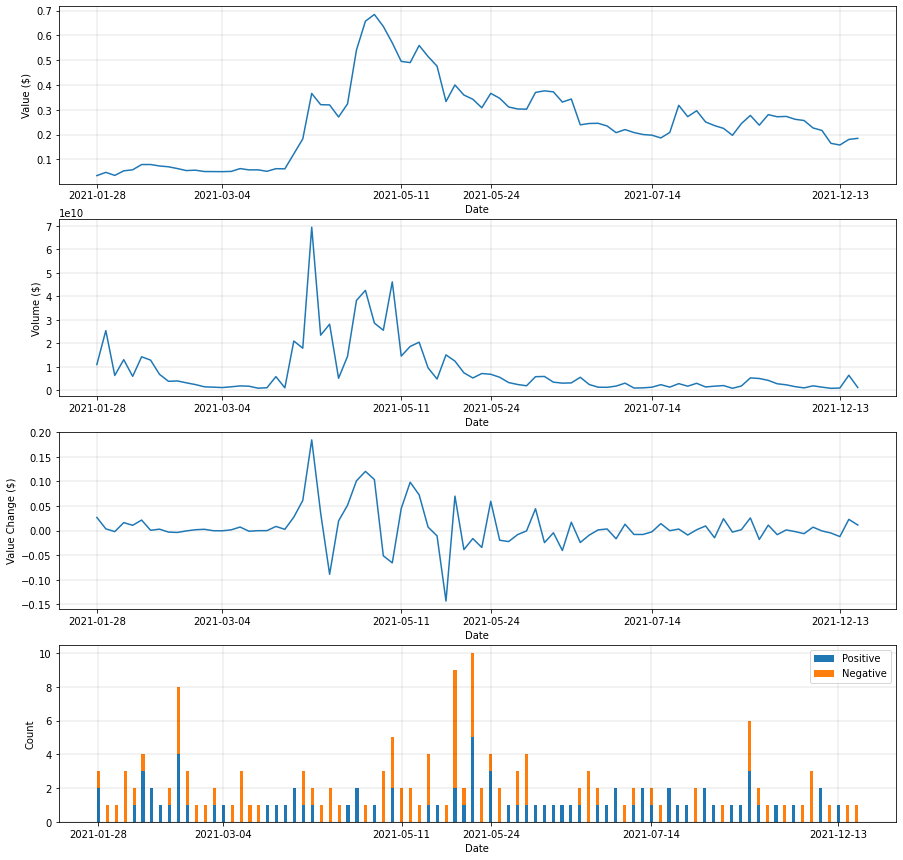

In [7]:
coin = 'BTC'
dateSelector = "2021-01|2021-02"
df = pd.read_csv(f'../twitter-scrapping/output/{coin}/all_results.csv')
df = df.sort_values(by='date', ascending=True)
coinDataFrame = pd.read_csv(f'../twitter-scrapping/coinsData/{coin}.csv')
coinDataFrame = coinDataFrame.sort_values(by='Time', ascending=True)
dateRange = df[df["date"].str.contains(dateSelector)]
tweetsDates = [date for date in dateRange['date']]
coinValues = []
coinVolumes = []
coinValueChange = []

pos_sum = []
neg_sum = []
for date in tweetsDates:
    pos_sum.append(dateRange[(dateRange['polarity'] == 'Positive') & (
        dateRange['date'] == date)].shape[0])
    neg_sum.append(dateRange[(dateRange['polarity'] == 'Negative') & (
        dateRange['date'] == date)].shape[0])
    row = coinDataFrame[coinDataFrame['Time'] == date]
    coinVolumes.append(row.Volume.ravel()[0])
    coinValues.append(row.Close.ravel()[0])
    coinValueChange.append(row.Close.ravel()[0]-row.Open.ravel()[0])
figure, axis = plt.subplots(4, 1)  # Create a figure containing 3 axes.
figure.set_figheight(15)
figure.set_figwidth(15)
# plt.xticks(rotation=90)
axis[0].plot(tweetsDates, coinValues)  # Plot some data on the axes
axis[0].set_ylabel('Value ($)')
axis[0].set_xlabel('Date')
axis[0].set_xticks(tweetsDates[::int(len(tweetsDates)/5)])
axis[0].grid(color='black', linestyle='-', linewidth=0.1)

axis[1].plot(tweetsDates, coinVolumes)  # Plot some data on the axes
axis[1].set_ylabel('Volume ($)')
axis[1].set_xlabel('Date')
axis[1].set_xticks(tweetsDates[::int(len(tweetsDates)/5)])
axis[1].grid(color='black', linestyle='-', linewidth=0.1)

axis[2].plot(tweetsDates, coinValueChange)  # Plot some data on the axes
axis[2].set_ylabel('Value Change ($)')
axis[2].set_xlabel('Date')
axis[2].set_xticks(tweetsDates[::int(len(tweetsDates)/5)])
axis[2].grid(color='black', linestyle='-', linewidth=0.1)

labels = tweetsDates
width = 0.35
axis[3].bar(labels, pos_sum, width, label='Positive')
axis[3].bar(labels, neg_sum, width, bottom=pos_sum, label='Negative')
axis[3].set_ylabel('Count')
axis[3].grid(color='black', linestyle='-', linewidth=0.1)
axis[3].set_xlabel('Date')
axis[3].set_xticks(tweetsDates[::int(len(tweetsDates)/5)])
axis[3].legend()
plt.show()
